<a href="https://colab.research.google.com/github/sp7412/colab/blob/master/distilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def softmax_sparse_categorical_crossentropy(labels, logits):
  softmaxed = tf.keras.backend.softmax(logits)

  return tf.keras.losses.sparse_categorical_crossentropy(labels, softmaxed)

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [34]:
num_classes = ds_info.features['label'].num_classes

In [7]:
ds_info.features['image'].shape

(28, 28, 1)

In [8]:
num_training_examples = ds_info.splits['train'].num_examples
num_training_examples

60000

In [9]:
ds_train_iter = ds_train.as_numpy_iterator()
train_images, train_labels = zip(*[ds_train_iter.next() for i in range(num_training_examples)])
train_images = np.asarray(train_images)

Text(0.5, 1.0, '4')

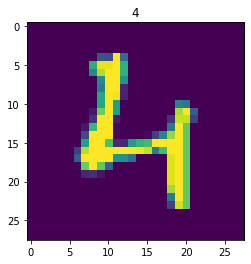

In [52]:
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(train_images[idx]))
plt.title(train_labels[idx])

9

In [10]:
train_images.shape

(60000, 28, 28, 1)

In [11]:
num_testing_examples = ds_info.splits['test'].num_examples
num_testing_examples

10000

In [12]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
ds_test_iter = ds_test.as_numpy_iterator()

In [14]:
test_images, test_labels = zip(*[ds_test_iter.next() for i in range(num_testing_examples)])

In [15]:
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
control_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(10, activation='softmax')])
  # tf.keras.layers.Dense(10, activation=None)])

control_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
# control_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# control_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
control_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)         

In [19]:
control_model.fit(ds_train, epochs=10)

test_loss, test_acc = control_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.9978 - accuracy: 0.7239
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3925 - accuracy: 0.9009
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2724 - accuracy: 0.9272
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2231 - accuracy: 0.9373
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1954 - accuracy: 0.9441
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1800 - accuracy: 0.9477
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1656 - accuracy: 0.9510
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1559 - accuracy: 0.9536
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1471 - accuracy: 0.9551
Epoch 10/10
79/79 [==============================] - 1s 19ms/step - loss: 0.1354 - accuracy: 0.9560


In [20]:
test_loss, test_acc = control_model.evaluate(np.asarray(test_images,dtype=np.float64),
                                             np.asarray(test_labels,dtype=np.float64))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1354 - accuracy: 0.9560
Test Loss: 0.1353527158498764
Test Accuracy: 0.9559999704360962


In [40]:
teacher_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  #tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

#teacher_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
teacher_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
teacher_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 6, 64)         

In [41]:
teacher_model.fit(ds_train, epochs=15)

test_loss, test_acc = teacher_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.3842 - accuracy: 0.8956
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1249 - accuracy: 0.9651
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0920 - accuracy: 0.9736
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0758 - accuracy: 0.9771
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0665 - accuracy: 0.9795
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0577 - accuracy: 0.9823
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0518 - accuracy: 0.9832
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0466 - accuracy: 0.9857
Epoch 9/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0456 - accuracy: 0.9858
Epoch 10/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0414 - accuracy: 0.9869

In [42]:
ds_train_images = tf.data.Dataset.from_tensor_slices(list(map(lambda x:tf.reshape(x,(-1,28,28,1)), train_images)))
soft_labels_train = teacher_model.predict(train_images,verbose=1)

1875/1875 [==============================] - 2s 1ms/step


In [48]:
soft_labels_train

array([[-3.2132983 ,  3.491695  , -2.608758  , ...,  5.2562127 ,
        -4.3469596 , -2.0890887 ],
       [-0.8473589 , 13.893081  , -1.3238841 , ...,  4.725108  ,
        -3.106113  , -3.4589026 ],
       [17.102049  ,  0.50875515, -1.7520702 , ..., -2.4097998 ,
        -3.6546803 , -2.2963073 ],
       ...,
       [ 3.3898787 ,  2.807206  ,  1.3815862 , ..., -5.788686  ,
        -3.890337  , -3.9900806 ],
       [-0.44898036, 13.447332  , -3.491755  , ...,  0.706247  ,
        -3.2284858 , -1.0321379 ],
       [-7.4827347 , -3.6161199 , -3.7202818 , ..., -0.63771945,
         4.3963366 ,  1.0665143 ]], dtype=float32)

In [27]:
temperature = 3
afterwards_temperature = 1

def temperature_softmax(logits):
  soft_logits = tf.keras.backend.exp(logits / temperature)
  return soft_logits / tf.keras.backend.sum(soft_logits, axis=-1, keepdims=True) / afterwards_temperature

def distillation_loss(labels, logits):
  labels = temperature_softmax(labels)
  logits = temperature_softmax(logits)

  return -tf.keras.backend.mean(labels * tf.keras.backend.log(logits))

In [28]:
student_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  # tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

student_model.compile('adam', distillation_loss, ['accuracy'])
student_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 6, 64)         

In [58]:
student_model.fit(train_images, soft_labels_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0560 - accuracy: 0.9591 - val_loss: 0.0511 - val_accuracy: 0.9759
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0559 - accuracy: 0.9598 - val_loss: 0.0520 - val_accuracy: 0.9734
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0559 - accuracy: 0.9599 - val_loss: 0.0513 - val_accuracy: 0.9759
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0557 - accuracy: 0.9614 - val_loss: 0.0516 - val_accuracy: 0.9748
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0557 - accuracy: 0.9623 - val_loss: 0.0516 - val_accuracy: 0.9731


In [59]:
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='scores')(student_model.layers[-1].output)
new_model = tf.keras.Model(student_model.input, output_layer)

In [61]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [62]:
new_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 6, 64)         

In [63]:
test_loss, test_acc = new_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 8.8057 - accuracy: 0.1479
Test Loss: 8.805712699890137
Test Accuracy: 0.14790000021457672


In [65]:
test_loss, test_acc = new_model.evaluate(np.asarray(test_images), np.asarray(test_labels), batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 8.8057 - accuracy: 0.1479
